In [0]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [0]:
train_paths = {"mawitrain":"unsw_train.pkl"}# here
test_paths = {"mawitest":"unsw_test.pkl"}#here

class preprocess:
    
    def get_data(paths):
        
        for key, value in paths.items():
            sample_data = pd.read_pickle(value)
            x = sample_data.iloc[:,:-2]#here
            y = sample_data.iloc[:,-2:]#here
            yield key, x.values, y.values

In [0]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq.python.ops.seq2seq import basic_rnn_seq2seq
from tensorflow.contrib.rnn import RNNCell, LSTMCell, MultiRNNCell
from sklearn import model_selection as ms
from sklearn import metrics as me

In [0]:
class network(object):
    
    input_dim = 39 #here
    classes = 2
    hidden_encoder_dim = 39
    hidden_layers = 3
    latent_dim = 5

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):
            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))
            #loss = tf.losses.mean_squared_error(labels = self.y_, predictions = self.y)
            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")
            
        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()

In [0]:
import collections
import time
from sklearn import model_selection as ms
from sklearn import metrics as me

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'quality_score', 'time_taken'])

    predictions = {}
    results = []
    
    best_acc = 0
    best_acc_global = 0
    
    def train(epochs, net, h,f, lrs):
        batch_iterations = 1000
        train_loss = None
        Train.best_acc = 0
        os.makedirs("hidden layers_{}_features count_{}".format(epochs,h,f),
                    exist_ok = True)
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()
            for c, lr in enumerate(lrs):
                for epoch in range(1, (epochs+1)):
                    
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.33)
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                                   net.regularized_loss, 
                                                                   ], #net.summary_op
                                                                  feed_dict={net.x: x_train[i,:], 
                                                                             net.y_: y_train[i,:], 
                                                                             net.keep_prob:0.5, net.lr:lr})

                            train_batch()
                            #summary_writer_train.add_summary(summary_str, epoch)
                            #print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                            while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                                print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('hidden_layers_{}_features_count_{}'
                                                                             .format(epochs,h,f)))
                                train_batch()


                        valid_accuracy = sess.run(net.regularized_loss, #net.summary_op 
                                                              feed_dict={net.x: x_valid, 
                                                                         net.y_: y_valid, 
                                                                         net.keep_prob:1, net.lr:lr})
                        #summary_writer_valid.add_summary(summary_str, epoch)
                    
                        print("Key {} | Training Loss: {:.6f} | Validation Loss: {:.6f}".format(key, train_loss, valid_accuracy))
                    
                    end_time = time.perf_counter() 
                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                                               net.pred, 
                                                                               net.actual, net.y], 
                                                                              feed_dict={net.x: x_test, 
                                                                                         net.y_: y_test, 
                                                                                         net.keep_prob:1, net.lr:lr})


                        q_score = me.matthews_corrcoef(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        accuracy = me.roc_auc_score(actual_value, pred_value)

                        print("Key {} Test Accuracy: {} Quality score: {}, recall {}, precision {}".format(key, accuracy, q_score, recall, prec))

                        if accuracy > Train.best_acc_global:
                            Train.best_acc_global = accuracy
                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual": actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):(curr_pred, 
                                                   Train.result(key, f, h, valid_accuracy, accuracy, q_score, end_time - start_time))})

                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))

In [0]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        print("********************************** Training ******************************")
        Train.predictions = {}
        Train.results = []
    
        
        features_arr = [39] #8, 16, 42
        hidden_layers_arr = [3]

        epochs = [10]
        lrs = [1e-2]
        print("***************************** Entering Loop **********************")
        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - hidden layers:{} features count:{}".format(h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)
            
        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)

        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

#         if not os.path.isfile('D:/AI/Jinoh Kim/MAWI/mawi_lab/scores/tf_dense_only_nsl_kdd_scores_all_f1.pkl'):
#             past_scores = df_results#temp
#         else:
#             past_scores = pd.read_pickle("D:/AI/Jinoh Kim/MAWI/mawi_lab/scores/tf_dense_only_nsl_kdd_scores_all_f1.pkl")

#         past_scores.append(df_results, ignore_index=True).to_pickle("D:/AI/Jinoh Kim/MAWI/mawi_lab/scores/tf_dense_only_nsl_kdd_scores_all_f1.pkl")

In [0]:
Hyperparameters.start_training()

********************************** Training ******************************
***************************** Entering Loop **********************
Current Layer Attributes - hidden layers:3 features count:39
Key mawitrain | Training Loss: 0.429139 | Validation Loss: 0.433316
Key mawitest Test Accuracy: 0.8658999397883854 Quality score: 0.6852623359209032, recall 0.9522857142857143, precision 0.6696048517723283
Key mawitrain | Training Loss: 0.461593 | Validation Loss: 0.410646
Key mawitest Test Accuracy: 0.8985035821720951 Quality score: 0.7556563459409107, recall 0.952, precision 0.7424139035496943
Key mawitrain | Training Loss: 0.420432 | Validation Loss: 0.396296
Key mawitest Test Accuracy: 0.8992043081529879 Quality score: 0.7576799637268629, recall 0.9505357142857143, precision 0.745674861665616
Key mawitrain | Training Loss: 0.481401 | Validation Loss: 0.398414
Key mawitest Test Accuracy: 0.882964704906229 Quality score: 0.7213045355039376, recall 0.9513392857142857, precision 0.70654

In [0]:
pd.Panel(Train.predictions).to_pickle("tf_dense_only_nsl_kdd_predictions_f1.pkl")
df_results.to_pickle("tf_dense_only_nsl_kdd_scores_f1.pkl")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive \n Type II Error"],
             ["\n False Negative \n Type I Error", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    con = tf.confusion_matrix(labels = actual_value, predictions = pred_value )
    sess = tf.Session()
    with sess.as_default():
        print(sess.run(con))
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)

In [0]:
# past_scores = pd.read_pickle("D:/AI/Jinoh Kim/MAWI/mawi_lab/scores/tf_dense_only_nsl_kdd_scores_all_f1.pkl")

In [0]:
# past_scores.sort_values(by='quality_score', ascending = False)

In [0]:
# psg = past_scores.sort_values(by='quality_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
# psg.first().sort_values(by='quality_score', ascending=False)

In [0]:
Train.predictions = pd.read_pickle("tf_dense_only_nsl_kdd_predictions_f1.pkl")

In [0]:
Train.predictions

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 175341 (major_axis) x 4 (minor_axis)
Items axis: mawitest_39_3 to mawitest_39_3
Major_axis axis: 0 to 175340
Minor_axis axis: Attack_prob to Actual

In [0]:
df = Train.predictions['mawitest_39_3'].dropna()

In [0]:
from sklearn import metrics as me
def get_score(y_true, y_pred):
    f1 = me.f1_score(y_true, y_pred)
    pre = me.precision_score(y_true, y_pred)
    rec = me.recall_score(y_true, y_pred)
    acc = me.accuracy_score(y_true, y_pred)
    return {"F1 Score":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}

In [0]:
from sklearn import metrics as me

scores = get_score(df.loc[:,'Actual'].values.astype(int),
                df.loc[:,'Prediction'].values.astype(int))
scores.update({"Scenario":"Train/Test1"})
score_df = pd.DataFrame(scores, index=[0])

score_df

,F1 Score,Precision,Recall,Accuracy,Scenario
0,0.833534,0.74037,0.953518,0.878363,Train/Test1


In [0]:
df.loc[:,'Prediction'].values.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.8335336632272365

In [0]:
df.groupby(by="Actual").Actual.count()

Actual
0.0    119341
1.0     56000
Name: Actual, dtype: int64

[[100616  18725]
 [  2603  53397]]


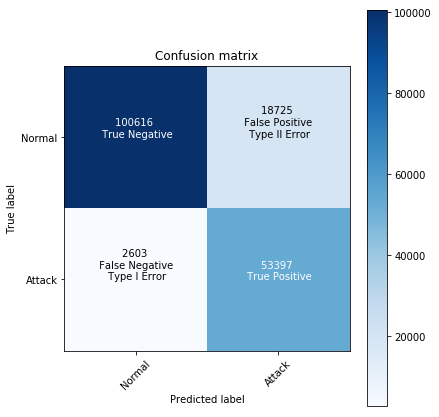

In [0]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))